In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CelebA
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CNN_CelebA(nn.Module):
    def __init__(self):
        super(CNN_CelebA, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(512*4, 128)
        self.z_log_var = nn.Linear(512*4, 128)

        self.decoder = nn.Sequential(
            nn.Linear(128, 512*4),
            nn.Unflatten(1, (512, 2, 2)),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),            
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 3, kernel_size= 3, padding= 1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(148),
        transforms.Resize(64),
        transforms.ToTensor()
    ]
)

trainset = CelebA(root='/media/mountHDD2/data', split='train', download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=24)
validset = CelebA(root='/media/mountHDD2/data', split='valid', download=True, transform=transform)
valid_dl = DataLoader(validset, batch_size=64, shuffle=False, num_workers=24)
testset = CelebA(root='/media/mountHDD2/data', split='test', download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=64, shuffle=False, num_workers=24)

print(len(trainset), len(validset), len(testset))
print(len(train_dl), len(valid_dl), len(test_dl))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
162770 19867 19962
2544 311 312


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_CelebA().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.005)

epochs = 10

beta = 10

kld_w = 0.00025

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + beta * kld_w * train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 127.46it/s]


Epoch: 0 - TrainRecLoss: 562.7452647251154 - ValidRecLoss: 458.90857510688977
Epoch: 0 - TrainDivLoss: 224590261134.98068 - ValidDivLoss: 15459.353663517879


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 130.43it/s]


Epoch: 1 - TrainRecLoss: 407.0140186285823 - ValidRecLoss: 385.1619234329615
Epoch: 1 - TrainDivLoss: 31592.628729574335 - ValidDivLoss: 5376.843933105469


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 133.70it/s]


Epoch: 2 - TrainRecLoss: 361.2522102691842 - ValidRecLoss: 390.25894194382886
Epoch: 2 - TrainDivLoss: 19017.300847563354 - ValidDivLoss: 4675.59267953726


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 129.43it/s]


Epoch: 3 - TrainRecLoss: 335.0928270351962 - ValidRecLoss: 332.87970782548956
Epoch: 3 - TrainDivLoss: 4742.070054827996 - ValidDivLoss: 3694.3689896021133


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 133.38it/s]


Epoch: 4 - TrainRecLoss: 316.53995134245673 - ValidRecLoss: 311.91566193409454
Epoch: 4 - TrainDivLoss: 3385.1307276119974 - ValidDivLoss: 2873.938296587039


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 133.21it/s]


Epoch: 5 - TrainRecLoss: 338.4974361095788 - ValidRecLoss: 326.3938810886481
Epoch: 5 - TrainDivLoss: 19254316.236315843 - ValidDivLoss: 2843.9596268091445


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 134.86it/s]


Epoch: 6 - TrainRecLoss: 303.4669768315441 - ValidRecLoss: 279.35497958843524
Epoch: 6 - TrainDivLoss: 3574.701690673828 - ValidDivLoss: 2133.9359263884717


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 132.12it/s]


Epoch: 7 - TrainRecLoss: 276.0704099547188 - ValidRecLoss: 261.7343404720991
Epoch: 7 - TrainDivLoss: 2124.869280641184 - ValidDivLoss: 1747.7926463591746


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 129.15it/s]


Epoch: 8 - TrainRecLoss: 263.79960775675266 - ValidRecLoss: 252.41910161727515
Epoch: 8 - TrainDivLoss: 1713.5809214370056 - ValidDivLoss: 1613.3086626101763


100%|█████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 131.67it/s]

Epoch: 9 - TrainRecLoss: 258.7006800909462 - ValidRecLoss: 250.15741108625363
Epoch: 9 - TrainDivLoss: 1628.1690121536735 - ValidDivLoss: 1595.0249739426833


In [7]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

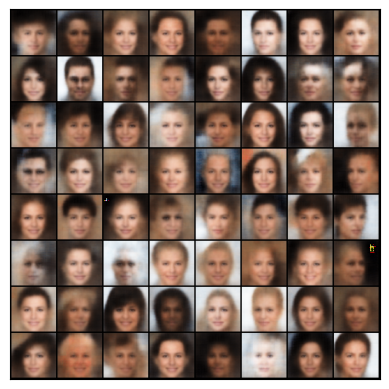

In [8]:
test_input, _ = next(iter(test_dl))
test_input = test_input.to(device)

model.eval()
with torch.no_grad():
    recons, _, _ = model(test_input)

grid = make_grid(recons)
show(grid)

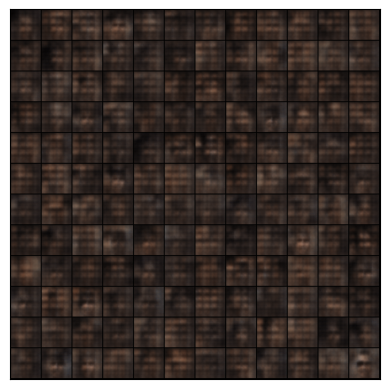

In [9]:
z = torch.randn(144, 128).to(device)

samples = model.decoder(z)

grid = make_grid(samples, nrow=12)
show(grid)